In [1]:
import requests
import pandas as pd
import sys
sys.path.append('src/')
sys.path.append('src/graphdb-client/')
import swagger_client
from recommender import ui, lib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
host = "http://localhost:7200"

In [3]:
headers = {"Accept": "application/sparql-results+json"}
url = host + "/repositories/TravelRegion"

In [4]:
allowed_regions = { reg: True  for reg in ui._region_descriptions }
empty_pref = { pref: False for pref in (ui._preferences1 + ui._preferences2) }

input1 = ui.DashboardData(2000, "january", 45, allowed_regions, empty_pref)

input2 = ui.DashboardData(2000, "february", 45, allowed_regions, empty_pref)

pref3 = empty_pref.copy()
pref3["nature"]=True
input3 = ui.DashboardData(2000, "january", 45, allowed_regions, pref3)

pref4=empty_pref.copy()
pref4["nature"]=True
pref4["beach"]=True
input4 = ui.DashboardData(2000, "march", 45, allowed_regions, pref4)

all_pref = { pref: True for pref in (ui._preferences1 + ui._preferences2) }
input5 = ui.DashboardData(2000, "december", 45, allowed_regions, all_pref)

In [5]:
result_dfs = []
inputs = [input1,input2,input3,input4,input5]

for i, user_in in enumerate(inputs,start=1):
    query = lib.buildQuery(user_in)
    resp = lib._sparql_client.execute_get_select_query('TravelRegion', query, query_ln='sparql', timeout=10, limit=0, offset=0)
    df = lib.readAPIResponse(resp)
    lib.rankRegions(user_in, df)
    df['User Input'] = "Input{}".format(i)
    result_dfs.append(df)

In [6]:
reduced_dfs = [_df[['region', 'score', 'User Input']] for _df in result_dfs]
appended_df = pd.concat(reduced_dfs)
appended_df

appended_top10_df = pd.concat([_df.nlargest(10, 'score')[['region', 'score', 'User Input']] for _df in result_dfs])

<AxesSubplot: xlabel='User Input', ylabel='score'>

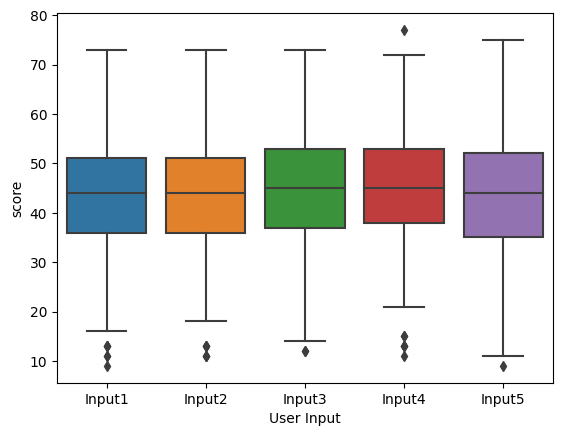

In [7]:
sns.boxplot(data=appended_df,x="User Input",y="score")

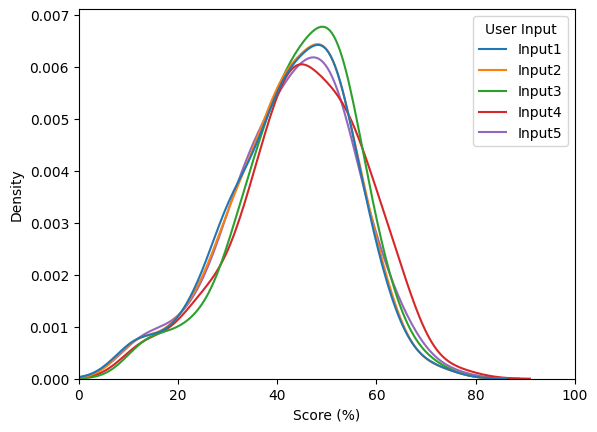

In [11]:
fig, ax = plt.subplots()
sns.kdeplot(data=appended_df, x="score", hue="User Input", ax=ax)
ax.set_xlim(0, 100)
ax.set_xlabel("Score (%)")
plt.show()

fig.savefig("score_density.pdf",format="pdf")

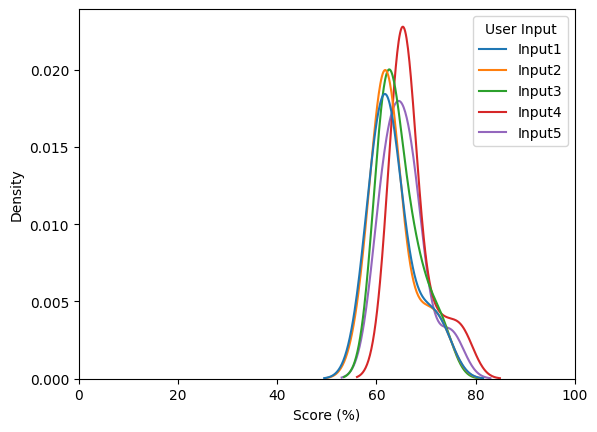

In [9]:
fig, ax = plt.subplots()
sns.kdeplot(data=appended_top10_df, x="score", hue="User Input", ax=ax)
ax.set_xlim(0, 100)
ax.set_xlabel("Score (%)")
plt.show()

#fig.savefig("score_density_top10.pdf",format="pdf")